## Assignment 1

In [233]:
# All Import Statements Defined Here
# Note: Do not add to this list.
# ----------------

import sys
assert sys.version_info[0]==3
assert sys.version_info[1] >= 5

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import nltk
nltk.download('reuters')
from nltk.corpus import reuters
import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

START_TOKEN = '<START>'
END_TOKEN = '<END>'

np.random.seed(0)
random.seed(0)
# ----------------

[nltk_data] Error loading reuters: <urlopen error [Errno 11004]
[nltk_data]     getaddrinfo failed>


## Part 1: Count-Based Word Vectors
### Plotting Co-Occurrence Word Embeddings

In [234]:
def read_corpus(category="crude"):
    """ Read files from the specified Reuter's category.
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
    """
    files = reuters.fileids(category)
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]

In [235]:
#reuters_corpus = read_corpus()
#pprint.pprint(reuters_corpus[:3], compact=True, width=100)

### Question 1.1: Implement distinct_words

In [236]:
def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): sorted list of distinct words across the corpus
            num_corpus_words (integer): number of distinct words across the corpus
    """
    corpus_words = []
    num_corpus_words = -1

    # ------------------
    # Write your implementation here.
    flattened_words = [y for x in corpus for y in x]
    distinct_words = list(set(flattened_words))
    corpus_words = sorted(distinct_words)
    num_corpus_words = len(corpus_words)
    # ------------------

    return corpus_words, num_corpus_words

In [237]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness.
# ---------------------

# Define toy corpus
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
test_corpus_words, num_corpus_words = distinct_words(test_corpus)

# Correct answers
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
ans_num_corpus_words = len(ans_test_corpus_words)

# Test correct number of words
assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)

# Test correct words
assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.2: Implement compute_co_occurrence_matrix

In [238]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).

        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.

              For example, if we take the document "<START> All that glitters is not gold <END>" with window size of 4,
              "All" will co-occur with "<START>", "that", "glitters", "is", and "not".

        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (a symmetric numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)):
                Co-occurence matrix of word counts.
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    words, num_words = distinct_words(corpus)
    M = None
    word2ind = {}

    # ------------------
    # Write your implementation here.
    word2ind = dict(zip(words, range(num_words)))
    M = np.zeros((num_words, num_words))

    for doc in corpus:
        traversed_idx = 0
        doc_len = len(doc)

        while traversed_idx < doc_len:
            left_boundary = max(traversed_idx - window_size, 0)
            right_boundary = min(traversed_idx + window_size, doc_len)
            outside_words = doc[left_boundary:traversed_idx] + doc[traversed_idx + 1:right_boundary + 1]
            center_word = doc[traversed_idx]
            center_idx = word2ind[center_word]

            for outside_word in outside_words:
                outside_idx = word2ind[outside_word]
                M[center_idx, outside_idx] += 1

            traversed_idx += 1
    # ------------------

    return M, word2ind

In [239]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# ---------------------

# Define toy corpus and get student's co-occurrence matrix
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

# Correct M and word2ind
M_test_ans = np.array(
    [[0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,],
     [1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,]]
)
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
word2ind_ans = dict(zip(ans_test_corpus_words, range(len(ans_test_corpus_words))))

# Test correct word2ind
assert (word2ind_ans == word2ind_test), "Your word2ind is incorrect:\nCorrect: {}\nYours: {}".format(word2ind_ans, word2ind_test)

# Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
for w1 in word2ind_ans.keys():
    idx1 = word2ind_ans[w1]
    for w2 in word2ind_ans.keys():
        idx2 = word2ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.3: Implement reduce_to_k_dim

In [240]:
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

        Params:
            M (numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))

        # ------------------
        # Write your implementation here.
    svd = TruncatedSVD(n_components = k, n_iter = n_iters)
    M_reduced = svd.fit_transform(M)
        # ------------------

    print("Done.")
    return M_reduced

In [241]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness
# In fact we only check that your M_reduced has the right dimensions.
# ---------------------

# Define toy corpus and run student code
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
M_test_reduced = reduce_to_k_dim(M_test, k=2)

# Test proper dimensions
assert (M_test_reduced.shape[0] == 10), "M_reduced has {} rows; should have {}".format(M_test_reduced.shape[0], 10)
assert (M_test_reduced.shape[1] == 2), "M_reduced has {} columns; should have {}".format(M_test_reduced.shape[1], 2)

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

Running Truncated SVD over 10 words...
Done.
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.4: Implement plot_embeddings

In [242]:
def plot_embeddings(M_reduced, word2ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2ind.
        Include a label next to each point.

        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , 2)): matrix of 2-dimensioal word embeddings
            word2ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """

    # ------------------
    # Write your implementation here.
    for word in words:
        word_idx = word2ind[word]
        word_coords = M_reduced[word_idx]
        x = word_coords[0]
        y = word_coords[1]
        plt.scatter(x, y, marker = 'x', color = 'red')
        plt.text(x, y, word, fontsize = 9)

    plt.show()
    # ------------------

--------------------------------------------------------------------------------
Outputted Plot:


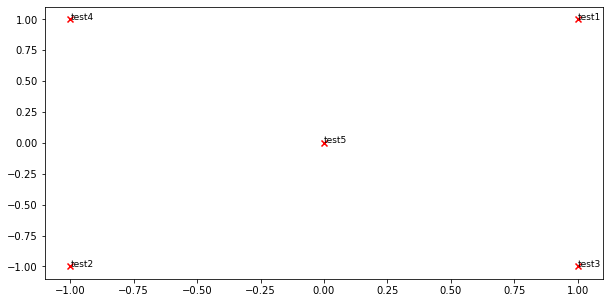

--------------------------------------------------------------------------------


In [243]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# The plot produced should look like the "test solution plot" depicted below.
# ---------------------

print ("-" * 80)
print ("Outputted Plot:")

M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(M_reduced_plot_test, word2ind_plot_test, words)

print ("-" * 80)

In [ ]:
# -----------------------------
# Run This Cell to Produce Your Plot
# ------------------------------
reuters_corpus = read_corpus()
M_co_occurrence, word2ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']

plot_embeddings(M_normalized, word2ind_co_occurrence, words)

Running Truncated SVD over 8185 words...


Clustered together:
1. petroleum, industry
2. energy, oil
3. irag, ecuador, kuwait

Not cluster together but doubt:
1. petroleum, oil

Since it seems that petroleum and oil have the same meaning, intuitively, they should be clustered together.

## Part 2: Prediction-Based Word Vectors

In [ ]:
def load_embedding_model():
    """ Load GloVe Vectors
        Return:
            wv_from_bin: All 400000 embeddings, each lengh 200
    """
    import gensim.downloader as api
    wv_from_bin = api.load("glove-wiki-gigaword-200")
    print("Loaded vocab size %i" % len(wv_from_bin.key_to_index.keys()))
    # wv_from_bin.vocab.keys()) -> wv_from_bin, otherwise, get error in Python 3.8
    return wv_from_bin

In [ ]:
# -----------------------------------
# Run Cell to Load Word Vectors
# Note: This will take a couple minutes
# -----------------------------------
wv_from_bin = load_embedding_model()

### Reducing dimensionality of Word Embeddings

In [ ]:
def get_matrix_of_vectors(wv_from_bin, required_words=['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']):
    """ Put the GloVe vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 400000 GloVe vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 200) containing the vectors
            word2ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_from_bin.key_to_index.keys())
    print("Shuffling words ...")
    random.seed(224)
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2ind and matrix M..." % len(words))
    word2ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.word_vec(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_from_bin.word_vec(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2ind

In [ ]:
# -----------------------------------------------------------------
# Run Cell to Reduce 200-Dimensional Word Embeddings to k Dimensions
# Note: This should be quick to run
# -----------------------------------------------------------------
M, word2ind = get_matrix_of_vectors(wv_from_bin)
M_reduced = reduce_to_k_dim(M, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced, axis=1)
M_reduced_normalized = M_reduced / M_lengths[:, np.newaxis] # broadcasting

### Question 2.1: GloVe Plot Analysis

In [ ]:
words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']
plot_embeddings(M_reduced_normalized, word2ind, words)

Clustered together:
1. energy, industry
2. irag, ecuador, petroleum

Not cluster together but doubt:
1. kuwait doesn't come along with irag and ecuador, although they are all oil provider countries

How different:
1. kuwait doesn't come along with irag and ecuador as the previous plot
2. industry is clustered with energy, instead of petroleum

Why different:
1. Maybe because the vectors in glove-wiki-gigaword-200 are trained by many other documents,
so after the plenty of training that is not limited to the Reuters (business and financial news) corpus with crude category,
it shows that kuwait is sort of not as similar as irag and ecuador, and industry are more frequently accompanied by
energy, instead of petroleum.

### Cosine Similarity
### Question 2.2: Words with Multiple Meanings

In [ ]:
# ------------------
# Write your implementation here.
print(wv_from_bin.most_similar('bare'))
print(wv_from_bin.most_similar('bond'))
print(wv_from_bin.most_similar('strike'))
print(wv_from_bin.most_similar('address'))
# ------------------

It's really interesting to see that in the first example of 'bare'. Among its top
10 similar words, 'covered' appears as well. I think these two words should be antonym.
The reason why 'covered' and 'bare' is cosine similar may be that they often appear together with
some common words in the contexts, but actually, in terms of denotational semantics,
they should have opposite meanings.

For other words like ’bond‘, one meaning is the financial terminology, and the other
is a kind of 'connection', like the phrase, family bond. However, the top 10 similar words are
more or less related to the meaning of financial terminology. None of them means
'connection'. Maybe because the documents or contexts it learns use the financial meaning the most of the time, or people tend to use it for financial
meaning more frequently than the 'connection'.


### Question 2.3: Synonyms & Antonyms

In [ ]:
# ------------------
# Write your implementation here.
w1 = 'exciting'
w2 = 'happy'
w3 = 'frustrating'
print(wv_from_bin.distance(w1, w2))
print(wv_from_bin.distance(w1, w3))
# ------------------

This question is sort of verifying the findings in the previous question. My guess is still
the same as before, that although exciting and frustrating are antonym, they are kind of
appearing together much more frequently than exciting and happy. That's quite reasonable, since, in the context, people may want to do a comparison between exciting and frustrating.
However, they may only use one of 'exciting' and 'happy' in the context, since they both
express the same meaning.

### Question 2.4: Analogies with Word Vectors

In [ ]:
# Run this cell to answer the analogy -- man : king :: woman : x
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'king'], negative=['man']))

We want to seek for $x$ where 'man is to king as woman is to $x$'.

As far as I'm concerned, 'man is to king' can be represented as 'vector(king) - vector(man)',
while 'woman is to $x$' is represented as 'vector($x$) - vector(woman)'.

Since 'man is to king' as 'woman is to x', therefore, roughly speaking, we want
'vector(king) - vector(man)' equals to 'vector($x$) - vector(woman)',
which means 'vector($x$)' equals to 'vector(woman) + vector(king) - vector(man)'.

Thus, we are maximizing cosine similarity $w + k - m$ with  $x$.

### Question 2.5: Finding Analogies

In [ ]:
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'actor'], negative=['man']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'waiter'], negative=['man']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'god'], negative=['man']))

### Question 2.6: Incorrect Analogy

In [ ]:
pprint.pprint(wv_from_bin.most_similar(positive=['butterfly', 'tadpole'], negative=['frog']))

Actually, I mean the child frog is a tadpole, so similarly, the child butterfly is
a caterpillar. It's like 'the frog is to tadpole as the butterfly is to caterpillar', where
the 'caterpillar' is our goal. However, for this analogy, it doesn't give my desired answer,
 maybe because it's too complicated and we should try some straightforward ones.

### Question 2.7: Guided Analysis of Bias in Word Vectors

In [ ]:
# Run this cell
# Here `positive` indicates the list of words to be similar to and `negative` indicates the list of words to be
# most dissimilar from.
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'worker'], negative=['man']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['man', 'worker'], negative=['woman']))

This example obviously reflects gender bias. Taking a close look at it, we could find that for
a woman, the position of the job or work is associated with nurse, pregnant, mother, teacher,
child, homemaker, things like that. However, for a man, the positions are laborer, mechanic, factory.

It's kind of saying that, the suitable careers for women are only nurse, teacher, homemaker,
and men always do the hard work related to laborer, mechanic, factory. But actually,
both women and men can do all these jobs.

Women definitely should have equal rights and choices as men, and they don't have to take care of her
family all the time. They can pursue their own career goal as well. So as for men, there's
no doubt that men can be househusbands whenever they want, and it's not a shame as well.

### Question 2.8: Independent Analysis of Bias in Word Vectors

In [ ]:
# ------------------
# Write your implementation here.
pprint.pprint(wv_from_bin.most_similar(positive=['black', 'police'], negative=['white']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['white', 'police'], negative=['black']))
# ------------------

### Question 2.9: Thinking About Bias

Bias may get into the word vectors through the reports and articles in the corpus, since these
words may occur together frequently in some passages. To test the bias, maybe we can find
words that often occur in biased cases according to experience, and calculate the similarity
regularly. Once it appears a significant difference between these two words, it means the biased
situation occurs.